# Ablation: Semi-Supervised Architope (Financial Data)
---
- This code Implements Algorithm 3.2 of the "Architopes" paper.

#### Mode: Code-Testin Parameter(s)

In [1]:
trial_run = True

### Meta-parameters

In [2]:
# Test-size Ratio
test_size_ratio = 1
min_height = 50
# Ablation Finess
N_plot_finess = 2

In [3]:
#------------------------------------#
# Only For Motivational Example Only #
#------------------------------------#
## Hyperparameters
percentage_in_row = .25
N = 5000

def f_1(x):
    return x
def f_2(x):
    return x**2
x_0 = 0
x_end = 1
import seaborn as sns

### Hyperparameters

Only turn of if running code directly here, typically this script should be run be called by other notebooks.  

In [4]:
# load dataset
results_path = "./outputs/models/"
results_tables_path = "./outputs/results/"
raw_data_path_folder = "./inputs/raw/"
data_path_folder = "./inputs/data/"

### Import

In [5]:
# Load Packages/Modules
exec(open('Init_Dump.py').read())
# Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Load Helper Function(s)
exec(open('Helper_Functions.py').read())
# Pre-process Data
if Option_Function != "Motivational_Example": 
    exec(open('Financial_Data_Preprocessor.py').read())
else:
    print(1)
    exec(open('Motivational_Example.py').read())
    print("Training Data size: ",X_train.shape[0])
# Import time separately
import time

# TEMP
# import pickle_compat
# pickle_compat.patch()
# param_grid_Vanilla_Nets['input_dim']=X_train.shape[1]

Using TensorFlow backend.


Deep Feature Builder - Ready
Deep Classifier - Ready
1
Training Data size:  5001


### Set Seed

In [6]:
random.seed(2021)
tf.random.set_seed(2021)

#### Pre-Process:
- Convert Categorical Variables to Dummies
- Remove Bad Column
- Perform Training/Test Split

# Random Lipschitz Partition Builder

We implement the random paritioning method of [Yair Bartal](https://scholar.google.com/citations?user=eCXP24kAAAAJ&hl=en):
- [On approximating arbitrary metrices by tree metrics](https://dl.acm.org/doi/10.1145/276698.276725)

The algorithm is summarized as follow:

---

## Algorithm:
 1. Sample $\alpha \in [4^{-1},2^{-1}]$ randomly and uniformly,
 2. Apply a random suffle of the data, (a random bijection $\pi:\{i\}_{i=1}^X \rightarrow \mathbb{X}$),
 3. For $i = 1,\dots,I$:
   - Set $K_i\triangleq B\left(\pi(i),\alpha \Delta \right) - \bigcup_{j=1}^{i-1} P_j$
 
 4. Remove empty members of $\left\{K_i\right\}_{i=1}^X$.  
 
 **Return**: $\left\{K_i\right\}_{i=1}^{\tilde{X}}$.  
 
 For more details on the random-Lipschitz partition of Yair Bartal, see this [well-written blog post](https://nickhar.wordpress.com/2012/03/26/lecture-22-random-partitions-of-metric-spaces/).

## Define Random Partition Builder

In [7]:
from scipy.spatial import distance_matrix

Here we use $\Delta_{in} = Q_{q}\left(\Delta(\mathbb{X})\right)$ where $\Delta(\mathbb{X})$ is the vector of (Euclidean) distances between the given data-points, $q \in (0,1)$ is a hyper-parameter, and $Q$ is the empirical quantile function.

In [8]:
def Random_Lipschitz_Partioner(Min_data_size_percentage,q_in, X_train_in,y_train_in, CV_folds_failsafe, min_size):
       
    #-----------------------#
    # Reset Seed Internally #
    #-----------------------#
    random.seed(2020)
    np.random.seed(2020)

    #-------------------------------------------#
    #-------------------------------------------#
    # 1) Sample radius from unifom distribution #
    #-------------------------------------------#
    #-------------------------------------------#
    alpha = np.random.uniform(low=.25,high=.5,size=1)[0]

    #-------------------------------------#
    #-------------------------------------#
    # 2) Apply Random Bijection (Shuffle) #
    #-------------------------------------#
    #-------------------------------------#
    X_train_in_shuffled = X_train_in#.sample(frac=1)
    y_train_in_shuffled = y_train_in#.sample(frac=1)

    #--------------------#
    #--------------------#
    # X) Initializations #
    #--------------------#
    #--------------------#
    # Compute-data-driven radius
    Delta_X = distance_matrix(X_train_in_shuffled,X_train_in_shuffled)[::,0]
    Delta_in = np.quantile(Delta_X,q_in)

    # Initialize Random Radius
    rand_radius = Delta_in*alpha

    # Initialize Data_sizes & ratios
    N_tot = X_train_in.shape[0] #<- Total number of data-points in input data-set!
    N_radios = np.array([])
    N_pool_train_loop = N_tot
    # Initialize List of Dataframes
    X_internal_train_list = list()
    y_internal_train_list = list()

    # Initialize Partioned Data-pool
    X_internal_train_pool = X_train_in_shuffled
    y_internal_train_pool = y_train_in_shuffled

    # Initialize counter 
    part_current_loop = 0

    #----------------------------#
    #----------------------------#
    # 3) Iteratively Build Parts #
    #----------------------------#
    #----------------------------#

    while ((N_pool_train_loop/N_tot > Min_data_size_percentage) or (X_internal_train_pool.empty == False)):
        # Extract Current Center
        center_loop = X_internal_train_pool.iloc[0]
        # Compute Distances
        ## Training
        distances_pool_loop_train = X_internal_train_pool.sub(center_loop)
        distances_pool_loop_train = np.array(np.sqrt(np.square(distances_pool_loop_train).sum(axis=1)))
        # Evaluate which Distances are less than the given random radius
        Part_train_loop = X_internal_train_pool[distances_pool_loop_train<rand_radius]
        Part_train_loop_y = y_internal_train_pool[distances_pool_loop_train<rand_radius]

        # Remove all data-points which are "too small"
        if X_internal_train_pool.shape[0] > max(CV_folds,4):
            # Append Current part to list
            X_internal_train_list.append(Part_train_loop)
            y_internal_train_list.append(Part_train_loop_y)

        # Remove current part from pool 
        X_internal_train_pool = X_internal_train_pool[(np.logical_not(distances_pool_loop_train<rand_radius))]
        y_internal_train_pool = y_internal_train_pool[(np.logical_not(distances_pool_loop_train<rand_radius))]

        # Update Current size of pool of training data
        N_pool_train_loop = X_internal_train_pool.shape[0]
        N_radios = np.append(N_radios,(N_pool_train_loop/N_tot))

        # Update Counter
        part_current_loop = part_current_loop +1
        
        # Update User
        print((N_pool_train_loop/N_tot))


    # Post processing #
    #-----------------#
    # Remove Empty Partitions
    N_radios = N_radios[N_radios>0]
    
    
    #-----------------------------------------------------------------#
    # Combine parts which are too small to perform CV without an error
    #-----------------------------------------------------------------#
    # Initialize lists (partitions) with "enough" datums per part
    X_internal_train_list_good = list()
    y_internal_train_list_good = list()
    X_small_parts = list()
    y_small_parts = list()
    # Initialize first list item test
    is_first = True
    # Initialize counter
    goods_counter = 0
    for search_i in range(len(X_internal_train_list)):
        number_of_instances_in_part = len(X_internal_train_list[search_i]) 
        if number_of_instances_in_part < max(CV_folds_failsafe,min_size):
            # Check if first 
            if is_first:
                # Initialize set of small X_parts
                X_small_parts = X_internal_train_list[search_i]
                # Initialize set of small y_parts
                y_small_parts = y_internal_train_list[search_i]

                # Set is_first to false
                is_first = False
            else:
                X_small_parts = X_small_parts.append(X_internal_train_list[search_i])
                y_small_parts = np.append(y_small_parts,y_internal_train_list[search_i])
#                 y_small_parts = y_small_parts.append(y_internal_train_list[search_i])
        else:
            # Append to current list
            X_internal_train_list_good.append(X_internal_train_list[search_i])
            y_internal_train_list_good.append(y_internal_train_list[search_i])
            # Update goods counter 
            goods_counter = goods_counter +1

    # Append final one to good list
    X_internal_train_list_good.append(X_small_parts)
    y_internal_train_list_good.append(y_small_parts)

    # reset is_first to false (inscase we want to re-run this particular block)
    is_first = True

    # Set good lists to regular lists
    X_internal_train_list = X_internal_train_list_good
    y_internal_train_list = y_internal_train_list_good
    
    
    
    # Return Value #
    #--------------#
    return [X_internal_train_list, y_internal_train_list, N_radios]

# Ablation Function:

In [11]:
def Ablate_PCNNs(q_inplicit_N_parts,data_y,X_train,X_test,y_test):
    #---------------------#
    # Building Partitions #
    #---------------------#

    ############# Partitioner Begin #######
    import time
    partitioning_time_begin = time.time()
    if Option_Function == 'SnP':
        q_in_auto = q_inplicit_N_parts
        Min_data_size_percentage_auto = .1
        min_size_part = 100
    else:
        if Option_Function == 'crypto':
            q_in_auto = .99
            Min_data_size_percentage_auto = .3
            min_size_part = 100
        if Option_Function == 'Motivational_Example':
            q_in_auto = q_inplicit_N_parts
            Min_data_size_percentage_auto = .5
            min_size_part = 10
            # Partition Based on Y
            holder_temp = data_y
            data_y = X_train
            X_train = holder_temp
        else:
            q_in_auto = .5
            Min_data_size_percentage_auto = .3
            min_size_part = 100

    # Initialize Number of Parts currently generated
    N_parts_generated = 0

    # Generate Partition (with option to regernerate if only 1 part is randomly produced)
    while N_parts_generated < 2:
        # Generate Parts
        X_parts_list, y_parts_list, N_ratios = Random_Lipschitz_Partioner(Min_data_size_percentage=Min_data_size_percentage_auto, 
                                                                          q_in=q_in_auto, 
                                                                          X_train_in=X_train, 
                                                                          y_train_in=data_y, 
                                                                          CV_folds_failsafe=CV_folds,
                                                                          min_size = min_size_part)

        # Update Number of Parts
        N_parts_generated = len(X_parts_list)
        # Shuffle hyperparameters
        Min_data_size_percentage_auto = (Min_data_size_percentage_auto + random.uniform(0,.3)) % 1
        q_in_auto = (q_in_auto + random.uniform(0,.3)) % 1

        # Update User
        print('The_parts_listhe number of parts are: ' + str(len(X_parts_list))+'.')

    # Trash removal (removes empty parts)
    X_parts_list = list(filter(([]).__ne__, X_parts_list))
    y_parts_list = list(filter(([]).__ne__, y_parts_list))


    # ICML Rebuttle Deadline = Coersion!
    if Option_Function == 'Motivational_Example':
        # Flipback After Partitioning Based on Y (since code was made for partitioning in X!)
        holder_temp = data_y
        data_y = X_train
        X_train = holder_temp
        holder_temp = y_parts_list
        y_parts_list = X_parts_list
        X_parts_list = holder_temp


    partitioning_time = time.time() - partitioning_time_begin
    print('The_parts_listhe number of parts are: ' + str(len(X_parts_list))+'.')
    # Record the number of parts:
    N_parts_Generated_by_Algo_2 = len(X_parts_list)
    ############# Partitioner End ########



    #-----------------------------------------------#
    # #### Building Training Predictions on each part
    #-----------------------------------------------#
    # - Train locally (on each "naive part")
    # - Generate predictions for (full) training and testings sets respectively, to be used in training the classifer and for prediction, respectively.  
    # - Generate predictions on all of testing-set (will be selected between later using classifier)

    # Time-Elapse (Start) for Training on Each Part #
    Architope_partition_training_begin = time.time()
    # Initialize running max for Parallel time
    Architope_partitioning_max_time_running = -math.inf # Initialize slowest-time at - infinity to force updating!
    # Initialize N_parameter counter for Architope
    N_params_Architope = 0


    tf.compat.v1.disable_eager_execution()
    # Silly Coercsion for ICML rebuttle deadline timeline
    if Option_Function == 'Motivational_Example':
        Iteration_Length = len(X_parts_list) -1
    else:
        Iteration_Length = len(X_parts_list)


    # Initialize Parameter Counter
    N_params_tally = 0
    # Train each part!
    for current_part in range(Iteration_Length):
        #==============#
        # Timer(begin) #
        #==============#
        current_part_training_time_for_parallel_begin = time.time()


        # Initializations #
        #-----------------#
        # Reload Grid
        exec(open('Grid_Enhanced_Network.py').read())
        # Modify heights according to optimal (data-driven) rule (with threshold)
        current_height = np.ceil(np.array(param_grid_Vanilla_Nets['height'])*N_ratios[current_part])
        current_height_threshold = np.repeat(min_height,(current_height.shape[0]))
        current_height = np.maximum(current_height,current_height_threshold)/N_parts_Generated_by_Algo_2
        current_height = current_height.astype(int).tolist()
        param_grid_Vanilla_Nets['height'] = current_height
        # Automatically Fix Input Dimension
        param_grid_Vanilla_Nets['input_dim'] = [X_train.shape[1]]
        param_grid_Vanilla_Nets['output_dim'] = [1]
        
        # Update Parameter Counter for PC-NNs (tally parameter count for sub-patterns)
        N_params_tally += (current_height[0])*(param_grid_Vanilla_Nets['depth'][0])

        # Update User #
        #-------------#
        print('Status: Current part: ' + str(current_part) + ' out of : '+str(len(X_parts_list)) +' parts.')
        print('Heights to iterate over: '+str(current_height))

        # Generate Prediction(s) on current Part #
        #----------------------------------------#
        # Failsafe (number of data-points)
        CV_folds_failsafe = min(CV_folds,max(1,(X_train.shape[0]-1)))
        # Train Network
        y_hat_train_full_loop, y_hat_test_full_loop, N_params_Architope_loop = build_ffNN(n_folds = CV_folds_failsafe, 
                                                                                          n_jobs = n_jobs,
                                                                                          n_iter = n_iter, 
                                                                                          param_grid_in = param_grid_Vanilla_Nets, 
                                                                                          X_train= X_parts_list[current_part], 
                                                                                          y_train=y_parts_list[current_part],
                                                                                          X_test_partial=X_train,
                                                                                          X_test=X_test,
                                                                                          NOCV=True)
        #put shape formats in order
        y_train.shape = (y_train.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        y_hat_train_full_loop.shape = (y_hat_train_full_loop.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        y_test.shape = (y_test.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        y_hat_test_full_loop.shape = (y_hat_test_full_loop.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        # Append predictions to data-frames
        ## If first prediction we initialize data-frames
        if current_part==0:
            # Register quality
            training_quality = np.array(np.abs(y_hat_train_full_loop-y_train))
            training_quality = training_quality.reshape(training_quality.shape[0],1)

            # Save Predictions
            predictions_train = y_hat_train_full_loop
            predictions_train = predictions_train.reshape(predictions_train.shape[0],1)
            predictions_test = y_hat_test_full_loop
            predictions_test = predictions_test.reshape(predictions_test.shape[0],1)


        ## If not first prediction we append to already initialized dataframes
        else:
        # Register Best Scores
            #----------------------#
            # Write Predictions 
            # Save Predictions
            y_hat_train_loop = y_hat_train_full_loop.reshape(predictions_train.shape[0],1)
            predictions_train = np.append(predictions_train,y_hat_train_loop,axis=1)
            y_hat_test_loop = y_hat_test_full_loop.reshape(predictions_test.shape[0],1)
            predictions_test = np.append(predictions_test,y_hat_test_loop,axis=1)

            # Evaluate Errors #
            #-----------------#
            # Training
            prediction_errors = np.abs(y_hat_train_loop-y_train)
            training_quality = np.append(training_quality,prediction_errors.reshape(training_quality.shape[0],1),axis=1)

        #============#
        # Timer(end) #
        #============#
        current_part_training_time_for_parallel = time.time() - current_part_training_time_for_parallel_begin
        Architope_partitioning_max_time_running = max(Architope_partitioning_max_time_running,current_part_training_time_for_parallel)

        #============---===============#

        # N_parameter Counter (Update) #
        #------------===---------------#
        N_params_Architope = N_params_Architope + N_params_Architope_loop

    # Update User
    #-------------#
    print(' ')
    print(' ')
    print(' ')
    print('----------------------------------------------------')
    print('Feature Generation (Learning Phase): Score Generated')
    print('----------------------------------------------------')
    print(' ')
    print(' ')
    print(' ')

    # Time-Elapsed Training on Each Part
    Architope_partition_training = time.time() - Architope_partition_training_begin








    #----------------------#
    # Train Deep Zero-Sets #
    #----------------------#
    #### Deep Classifier
    # Prepare Labels/Classes
    # Time-Elapsed Training Deep Classifier
    Architope_deep_classifier_training_begin = time.time()
    # Initialize Classes Labels
    partition_labels_training_integers = np.argmin(training_quality,axis=-1)
    partition_labels_training = pd.DataFrame(pd.DataFrame(partition_labels_training_integers) == 0)
    # Build Classes
    for part_column_i in range(1,(training_quality.shape[1])):
        partition_labels_training = pd.concat([partition_labels_training,
                                               (pd.DataFrame(partition_labels_training_integers) == part_column_i)
                                              ],axis=1)
    # Convert to integers
    partition_labels_training = partition_labels_training+0
    #### Re-Load Grid and Redefine Relevant Input/Output dimensions in dictionary.
    # Re-Load Hyper-parameter Grid
    exec(open('Grid_Enhanced_Network.py').read())
    # Re-Load Helper Function(s)
    exec(open('Helper_Functions.py').read())
    param_grid_Deep_Classifier['input_dim'] = [X_train.shape[1]]
    param_grid_Deep_Classifier['output_dim'] = [partition_labels_training.shape[1]]
    ## Re-adjust heights
    param_grid_Deep_Classifier['height'] = [int(max(round(param_grid_Deep_Classifier['height'][0]/N_parts_Generated_by_Algo_2,0),1))]

    
    # Update Parameter Counter for PC-NNs (tally parameter count for sub-patterns)
    N_params_tally += (param_grid_Deep_Classifier['height'][0])*(param_grid_Deep_Classifier['depth'][0])
    
    #### Train Deep Classifier
    # Train simple deep classifier
    tf.compat.v1.disable_eager_execution()
    predicted_classes_train, predicted_classes_test, N_params_deep_classifier = build_simple_deep_classifier(n_folds = CV_folds, 
                                                                                                        n_jobs = n_jobs, 
                                                                                                        n_iter =n_iter, 
                                                                                                        param_grid_in=param_grid_Deep_Classifier, 
                                                                                                        X_train = X_train.values, 
                                                                                                        y_train = partition_labels_training.values,
                                                                                                        X_test = X_test.values)
    # COMMENT: .values() is used to convert the Pandas Dataframes here, and not in the vanilla ffNNs, since the former is coded in Keras and the latter in tensorflow.  
    # Time-Elapsed Training Deep Classifier
    Architope_deep_classifier_training = time.time() - Architope_deep_classifier_training_begin

    ##### Get Binary Classes (Discontinuous Unit)
    #Maps deep classifier's outputs $\tilde{C}(x)\triangleq \hat{s}(x)$ to deep zero-sets $I_{(.5,1]}\circ \sigma_{\mbox{sigmoid}}(\tilde{C}(x))$.

    # Training Set
    predicted_classes_train = ((predicted_classes_train>.5)*1).astype(int)
    #### OLD: Architope_prediction_y_train = np.take_along_axis(predictions_train, predicted_classes_train[:,None], axis=1)
    # Testing Set
    predicted_classes_test = ((predicted_classes_test > .5)*1).astype(int)
    #### OLD: Architope_prediction_y_test = np.take_along_axis(predictions_test, predicted_classes_test[:,None], axis=1)
    #### Get PC-NN Prediction(s)
    # Comuptes $\sum_{n=1}^N \, \hat{f}(x)\cdot I_{K_n}$
    # Train
    Architope_prediction_y_train = (predictions_train*predicted_classes_train).sum(axis=1)
    # Test
    Architope_prediction_y_test = (predictions_test*predicted_classes_test).sum(axis=1)


    # Compute Peformance
    performance_Architope = reporter(y_train_hat_in=Architope_prediction_y_train,
                                    y_test_hat_in=Architope_prediction_y_test,
                                    y_train_in=y_train,
                                    y_test_in=y_test)
    # Write Performance
    performance_Architope.to_latex((results_tables_path+"Architopes_full_performance.tex"))

    # Update User
    print(performance_Architope)

    ### Model Complexity/Efficiency Metrics
    # Compute Parameters for composite models #
    #-----------------------------------------#
    N_params_Architope_full = N_params_Architope + N_params_deep_classifier

    # Build AIC-like Metric #
    #-----------------------#
    AIC_like = 2*(N_params_Architope_full - np.log((performance_Architope['test']['MAE'])))
    AIC_like = np.round(AIC_like,3)
    Efficiency = np.log(N_params_Architope_full) *(performance_Architope['test']['MAE'])
    Efficiency = np.round(Efficiency,3)


    # Build Table #
    #-------------#
    Architope_Model_Complexity_full = pd.DataFrame({'L-time': [Architope_partition_training],
                                                  'P-time':[Architope_partitioning_max_time_running],
                                                  'N_params_expt': [N_params_Architope_full],
                                                  'AIC-like': [AIC_like],
                                                  'Eff': [Efficiency]})


    # Write Required Training Time(s)
    Architope_Model_Complexity_full.to_latex((results_tables_path+"Architope_full_model_complexities.tex"))

    #--------------======---------------#
    # Display Required Training Time(s) #
    #--------------======---------------#
    print(Architope_Model_Complexity_full)
    
    # Return Performance Metrics
    return performance_Architope, Architope_Model_Complexity_full, N_parts_Generated_by_Algo_2, N_params_tally

---
# Perform Ablation:
---

In [12]:
# Initialize 
q_implicit_N_parts_possibilities = 0.99- np.array(range(N_plot_finess))/N_plot_finess

# Get Performance Metric
for inplicit_N_parts_loop in range(N_plot_finess):
    # Implicitly Set: Current Number of Parts
    q_implicit_N_parts_loop = q_implicit_N_parts_possibilities[inplicit_N_parts_loop]
    # Run Algos. 1+2
    performance_Architope_loop, Architope_Model_Complexity_full_loop, N_parts_Generated_by_Algo_2_loop, N_params_architope_loop = Ablate_PCNNs(q_implicit_N_parts_loop,data_y,X_train,X_test,y_test)
    # Reshape
    performance_Architope_loop = performance_Architope_loop.to_numpy().reshape([3,2,1])
    Architope_Model_Complexity_full_loop = Architope_Model_Complexity_full_loop.to_numpy().reshape([1,5,1])

    # Record
    if inplicit_N_parts_loop == 0:
        performance_Architope_history = performance_Architope_loop
        Architope_Model_Complexity_history = Architope_Model_Complexity_full_loop
        N_parts_Generated_by_Algo_2_history = N_parts_Generated_by_Algo_2_loop
        N_params_architope_hist = N_params_architope_loop
    else:
        performance_Architope_history = np.concatenate((performance_Architope_history,performance_Architope_loop),axis=2)
        Architope_Model_Complexity_history = np.concatenate((Architope_Model_Complexity_history,Architope_Model_Complexity_full_loop),axis=2)
        N_parts_Generated_by_Algo_2_history = np.append(N_parts_Generated_by_Algo_2_history,N_parts_Generated_by_Algo_2_loop)
        N_params_architope_hist = np.append(N_params_architope_hist,N_params_architope_loop)

0.365126974605079
0.006798640271945611
0.0
The_parts_listhe number of parts are: 4.
The_parts_listhe number of parts are: 3.
Status: Current part: 0 out of : 3 parts.
Heights to iterate over: [16]
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 3175 samples
3175/3175 [==============================] - 1s 176us/sample - loss: 0.2143 - mse: 0.0674 - mae: 0.2143 - mape: 235.9894
Status: Current part: 1 out of : 3 parts.
Heights to iterate over: [16]
Train on 1792 samples
1792/1792 [==============================] - 0s 246us/sample - loss: 0.6365 - mse: 0.4272 - mae: 0.6365 - mape: 88.0382
 
 
 
----------------------------------------------------
Feature Generation (Learning Phase): Score Generated
----------------------------------------------------
 
 
 
Deep Feature Builder - Ready
Deep Classifier - Ready
Train on 5001 samples
5001/5001 [==============================] - 1s 116us/sample - loss: 0.4916 - accuracy: 0.8328
           train        

/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:298: RuntimeWarning: divide by zero encountered in log


0.674865026994601
0.4299140171965607
0.2501499700059988
0.05118976204759048
0.0
The_parts_listhe number of parts are: 6.
The_parts_listhe number of parts are: 5.
Status: Current part: 0 out of : 5 parts.
Heights to iterate over: [10]
Train on 1626 samples
1626/1626 [==============================] - 0s 285us/sample - loss: 0.0329 - mse: 0.0021 - mae: 0.0329 - mape: 169.2138
Status: Current part: 1 out of : 5 parts.
Heights to iterate over: [10]
Train on 1225 samples
1225/1225 [==============================] - 0s 370us/sample - loss: 0.2964 - mse: 0.0930 - mae: 0.2964 - mape: 112.7683
Status: Current part: 2 out of : 5 parts.
Heights to iterate over: [10]
Train on 899 samples
899/899 [==============================] - 0s 522us/sample - loss: 0.5451 - mse: 0.2993 - mae: 0.5451 - mape: 109.6921
Status: Current part: 3 out of : 5 parts.
Heights to iterate over: [10]
Train on 995 samples
995/995 [==============================] - 0s 490us/sample - loss: 0.7337 - mse: 0.5417 - mae: 0.7337 -

/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:298: RuntimeWarning: divide by zero encountered in log


In [13]:
# Randomization may produce duplicates; we remove these with the following snippet:
get_unique_entries = np.unique(N_parts_Generated_by_Algo_2_history, return_index=True)[1]
N_parts_Generated_by_Algo_2_history_report = N_parts_Generated_by_Algo_2_history[get_unique_entries]
## Prediction Qualities
performance_Architope_history_report_MAE_train = (performance_Architope_history[1,0,:])[get_unique_entries]
performance_Architope_history_report_MAE_test = (performance_Architope_history[1,1,:])[get_unique_entries]
performance_Architope_history_report_MSE_train = (performance_Architope_history[0,0,:])[get_unique_entries]
performance_Architope_history_report_MSE_test = (performance_Architope_history[0,1,:])[get_unique_entries]
## Model Complexities
L_Times = (Architope_Model_Complexity_history[:,0].reshape(-1,))[get_unique_entries]
P_Times = (Architope_Model_Complexity_history[:,1].reshape(-1,))[get_unique_entries]
N_Params = (N_params_architope_hist.reshape(-1,))[get_unique_entries]
AIC_Like = (Architope_Model_Complexity_history[:,3].reshape(-1,))[get_unique_entries]
Eff = (Architope_Model_Complexity_history[:,4].reshape(-1,))[get_unique_entries]

---
## Plots
---

## MAE

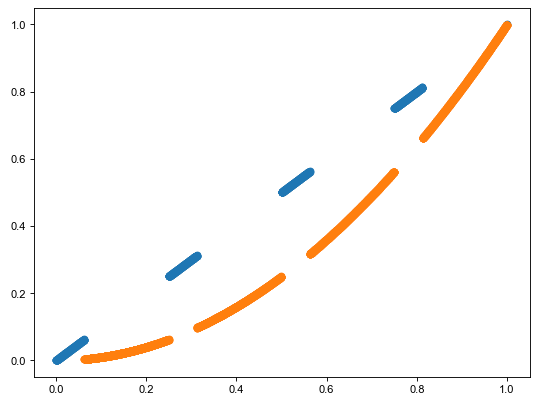

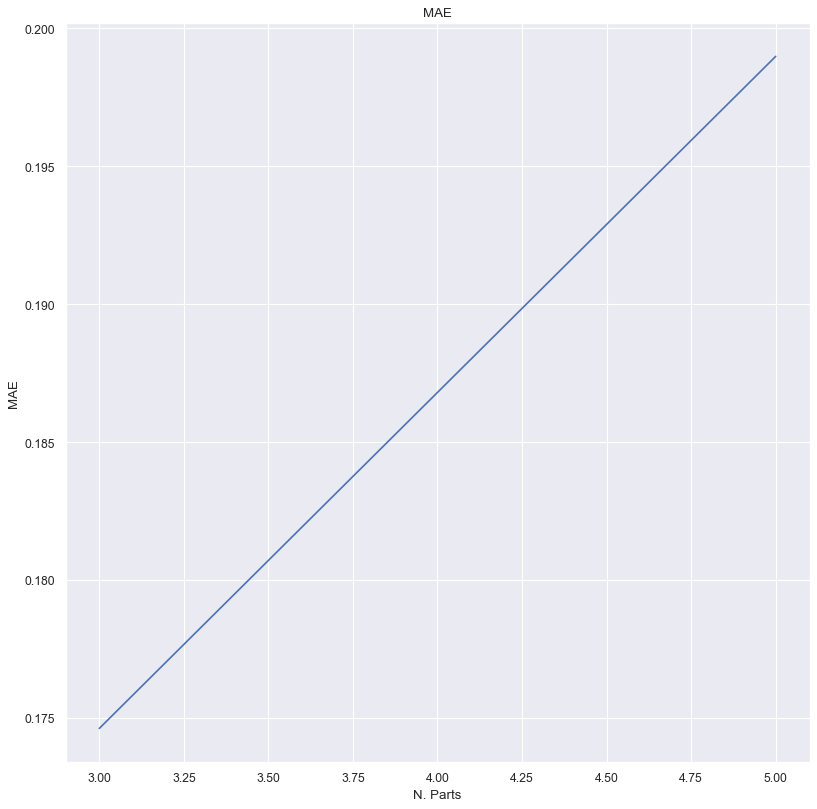

In [14]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("MAE")
plt.xlabel("N. Parts")
plt.ylabel("MAE")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         performance_Architope_history_report_MAE_test)


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_MAE_test.pdf', format='pdf')
plt.show()

## MSE

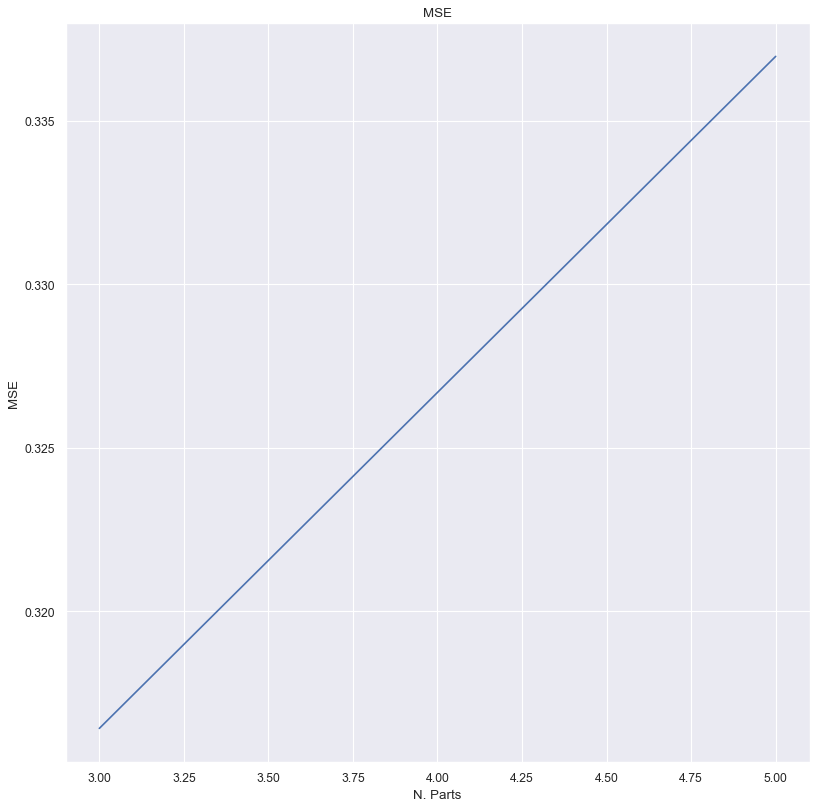

In [15]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("MSE")
plt.xlabel("N. Parts")
plt.ylabel("MSE")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         performance_Architope_history_report_MSE_test)


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_MSE_test.pdf', format='pdf')
plt.show()

# L-Time

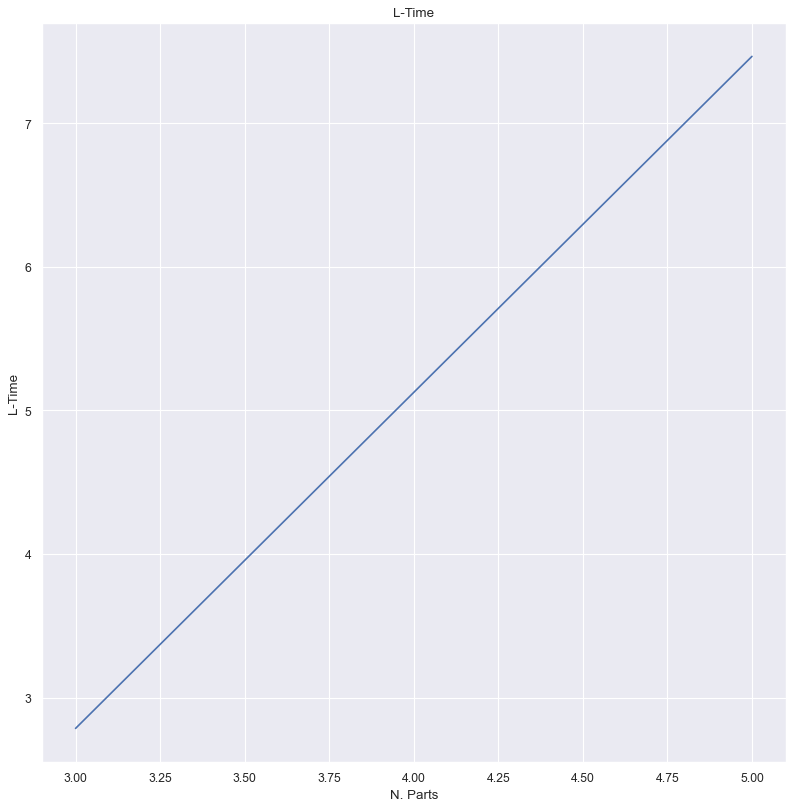

In [16]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("L-Time")
plt.xlabel("N. Parts")
plt.ylabel("L-Time")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         L_Times)


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_L_Time.pdf', format='pdf')
plt.show()

# P-Times

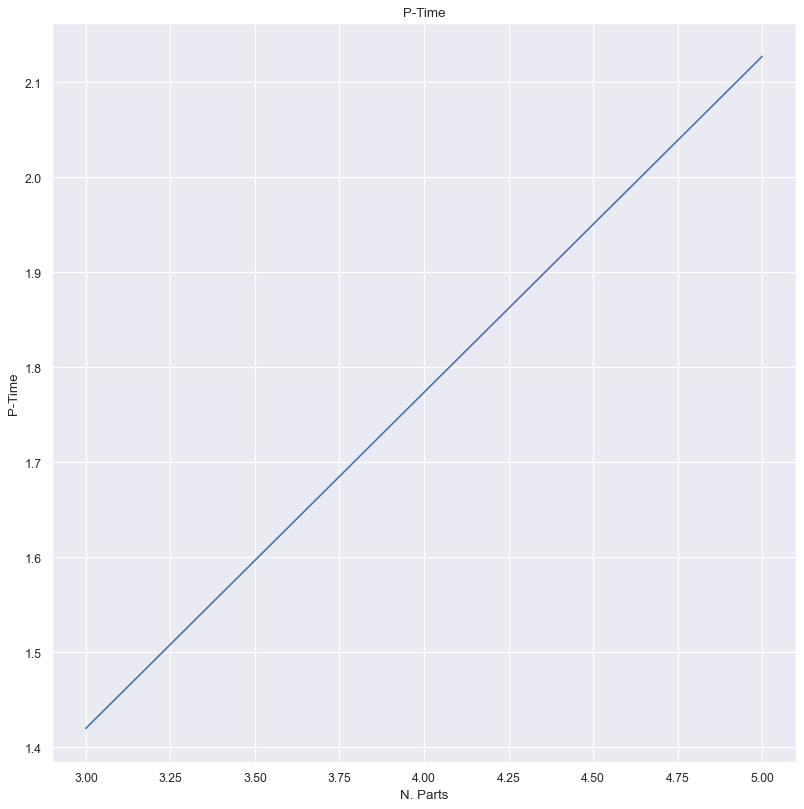

In [17]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("P-Time")
plt.xlabel("N. Parts")
plt.ylabel("P-Time")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         P_Times)


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_P_Time.pdf', format='pdf')
plt.show()

## N-Params

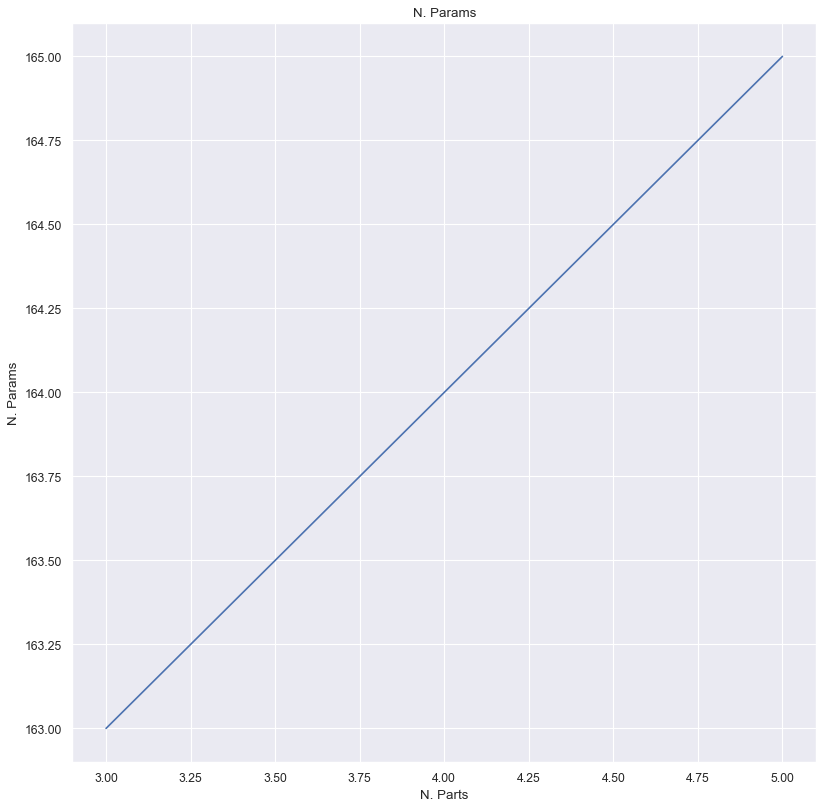

In [18]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("N. Params")
plt.xlabel("N. Parts")
plt.ylabel("N. Params")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_Params)


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_N_Params.pdf', format='pdf')
plt.show()

## AIC-Like

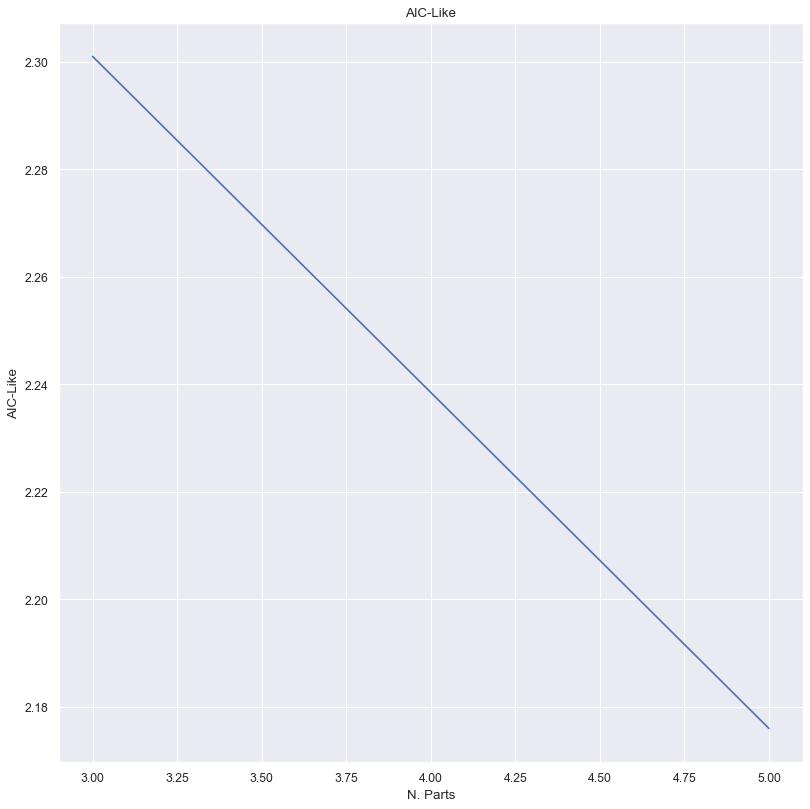

In [19]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("AIC-Like")
plt.xlabel("N. Parts")
plt.ylabel("AIC-Like")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         AIC_Like)


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_AIC_Like.pdf', format='pdf')
plt.show()

## Efficiency Metric

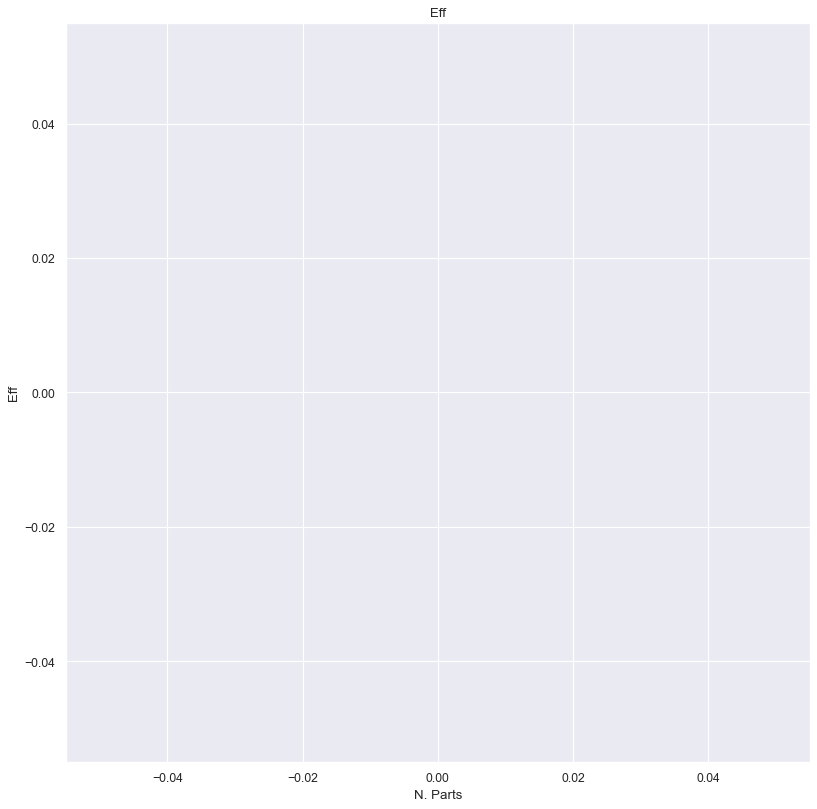

In [20]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("Eff")
plt.xlabel("N. Parts")
plt.ylabel("Eff")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         Eff)


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_Eff.pdf', format='pdf')
plt.show()

---
# Fin
---